# Vicsek Model
###### Rebecca Crossley(1708811), Yulin Zhang, Shancheng Wang & Katy Fellingham

## Contents
1. Introduction
- Functions
- Flocking Simulations
- Phase Transition 
- Predators
- References

This research concerns a mathematical model describing active matter: the Vicsek Model of flocking in birds, as initially proposed by Tamas Vicsek in 1995.

In order to form this mathematical model in Python we need the following:

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from scipy import stats
from scipy import spatial
import pandas as pd

The collective motion as described in the Vicsek Model is the simplest form of spontaneous phenomenon where birds interact and respond to the behaviour of other individuals local to itself. 

In this, we model each bird as a weightless point particle moving with an initial constant velocity of $v_0$ along a polar direction $\hat{n}=(cos \theta,sin \theta)$. Then, in order to create a swarming behaviour, the birds check in at each discrete time step with all of its neighbours within a radius $R$ and reorientate themselves along the mean direction of all birds within the region. Since birds are natural, they are imperfect creatures and so we take account for this by adding a random normally distributed noise term, $\eta_i$, with mean 0 and variance $\sigma$ into its new direction.

### Functions

In order to produce visual plots of the birds swarming, we must begin by introducing a function that calculates the distance between two birds, which we denote $p_1$ and $p_2$ under our calculated boundary conditions, even over the edges of our container. 

Our boundary conditions have been calculated to ensure birds disappearing out of the right re-enter on the left, and those disappearing off the top re-appear in the bottom. This is done using the 2 co-ordinates $(x_1,y_1)$ and $(x_2,y_2)$. Then $\forall t_1,t_2 \in [0, \pm 1]$ we consider for points $(x_2+t_1,y_2+t_1)$, then $$(y_2+t_2-y_1)^2+(x_2+t_1-x_1)^2$$ $$=(y_2-y_1)^2+(x_2-x_1)^2+t_1^2+2t_1(x_2-x_1)+t_2^2+2t_2(y_2-y_1)$$
We can note that $x_1,vx_2, y_1, y_2$ are fixed constants, so we now think about minimizing the latter terms including $t_1$ and $t_2$ separately. 

Consider minimising $t_1$ in the term $t_1^2+2(x_2-x_1)t_1$. So by differentiation to find the minimum, we look at $ |t_1 - (x_2-x_1)|$. Within the bounds of $L$ and $-L$, we have 3 cases:

Firstly, if $x_1-x_2<-\frac{L}{2}$ then $t_1=-L$. If $-\frac{L}{2}\leq{x_1-x_2}\leq \frac{L}{2}$ then $t_1=0$. If $x_1-x_2 > \frac{L}{2}$ then $t_1=L$. 

Similarly for $t_2$ terms, if $y_1-y_2<-\frac{L}{2}$ then $t_2=-L$. If $-\frac{L}{2}\leq{y_1-y_2}\leq \frac{L}{2}$ then $t_2=0$. If $y_1-y_2 > \frac{L}{2}$ then $t_2=L$. 


![Points as considered](\img\BCspic.png)

In [5]:
## return the distance matrix(N*N) calculated from birds positions
def cal_pdist(pos,N,L):
    Dist = np.zeros((N,N))
    # calculate the distance between p1(ith bird) and p2(jth bird) under boundary conditions
    for i in range(1,N):
        for j in range(i):
            t1 = 0
            t2 = 0
            dx = pos[j,0] - pos[i,0]
            dy = pos[j,1] - pos[i,1]
            if dx > L/2:
                t1 = -L
            if dx < -L/2:
                t1 = L
            if dy > L/2:
                t2 = -L
            if dy < -L/2:
                t2 = L    
            Dist[i,j] = Dist[j,i] = np.sqrt((dx + t1)**2+(dy + t2)**2)
    return Dist

We need to define our initial positions of the birds. Since these are modelled as weightless particles we are using uniformly random positions and orientations as initial states for our birds. 

In [6]:
# initialize the state of birds
def initialize(L,N):
    state = np.zeros((N,3))
    state[:,:2] = np.random.uniform(0,L,(N,2)) # positions x,y from uniform random dist 
    state[:,2] = np.random.uniform(0,2*np.pi,N) # angles theta from uniform random dist in [0,2pi]
    return state

In this model, the birds' position is considered at each discrete time step, and then updated as required by its neighbouring birds. 

In 2D, we can define the equations of motion of bird $i$ at time $t+1$ by: $$\vec{r_i}(t+1)=\vec{r_i}(t)+\hat{n}_i v_0$$ $$\theta_i(t+1)=\sum_{j=1}^{z_i}{\hat{n}_j}+\eta_i$$ where $r_i$ is the position, $\theta_i$ is the orientation, $n_i$ is the mean polar direction, $v_0$ is the constant intial velocity of all birds and  $z_i$ is the total number of neighbours within our defined neighbouring radius $R$.

The function to do this for each time step is given below. 

In [7]:
# update the state of birds in each time step
def update(state, L, v0, R, eta): 
    N=len(state)
    # Initialise heading with noise
    heading = eta
    
    # Use adjacency matrix to determine neighbours
    A = cal_pdist(state[:,:2],N,L)
    for i in range(N):
        adj = np.where(A[i,:] < R)[0] # indices of adjacent particles
        theta = state[adj,2] # angles of all adjacent particles
        
        # Sum sin and cos of angles
        sum_sin = np.sum(np.sin(theta))
        sum_cos = np.sum(np.cos(theta))
        
        # Compute heading for this particle
        heading[i] += np.arctan2(sum_sin, sum_cos)
        
    # Update state with new headings
    state[:,2] = heading 
    # Update positions(mod L)
    state[:,0] = (state[:,0] + v0*np.cos(state[:,2]))%L
    state[:,1] = (state[:,1] + v0*np.sin(state[:,2]))%L
    return state

The other function we will find useful, is to calculate the Vicsek Order Parameter, measuring alignment of birds, for each time step. This is defined as: $$n=\frac{1}{N} \sum_{i=1}^{N} \hat{n_i}$$ and calculate using the following function.

In [8]:
# calculate order parameter
def order_para(state):
    N=len(state)
    x = np.sum(np.cos(state[:,2]))
    y = np.sum(np.sin(state[:,2]))
    order_para = np.sqrt(x**2+y**2)/N
    return order_para

### Flocking Simulations

For 200 birds in a 15 x 15 container, we consider the following scenario. The initial velocity is 0.5 and the search radius is 1. We choose $\sigma=0.01$, and simulate this over 10,000 time steps.

<Figure size 432x1728 with 0 Axes>

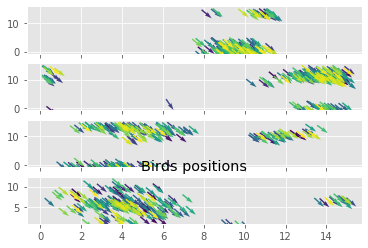

In [55]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 0.01  # variance of noise
T = 10000  # total time steps
Noise_generator = stats.norm(0,sigma)
opara = np.zeros(T) # the Vicsek order parameter
plt.figure(figsize=(6,24))
i=0
fig, axes = plt.subplots(nrows=4,sharex=True)
state = initialize(L,N)
for t in range(T):
    eta = Noise_generator.rvs(N) # noise term
    state = update(state, L, v0, R, eta)
    opara[t]=order_para(state)
    #Initial tests：999 ，3999，6999，9999
    if (t-999)%3000 == 0:
        axes[i].quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),np.arange(N))
        i+=1
plt.title('Birds positions')
plt.show()

Now for $T=10,000$ steps, we plot the Vicsek order parameter (as calculated in the above cell) against the time. 

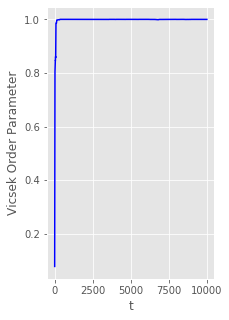

In [56]:
plt.figure(figsize=(3,5))
plt.plot(np.arange(T),opara,'b')   
plt.xlabel('t')
plt.ylabel('Vicsek Order Parameter')
plt.show()

We use these images as produced above at a variety of time steps to create an animation of the birds' motion for 10000 steps. 

In [54]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 0.01  # variance of noise
T = 10000  # total time steps
Noise_generator = stats.norm(0,sigma)

import os

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
        
createFolder('./pics/')

state = initialize(L,N)
for t in range(T):
    eta = Noise_generator.rvs(N) # noise term
    state = update(state, L, v0, R, eta)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),np.arange(N)) 
    ax.set_xlim(0,15)
    ax.set_ylim(0,15)
    fig.savefig('pics/{}.png'.format(t))
    plt.close(fig)

KeyboardInterrupt: 

In [ ]:
# make a video
import cv2
import numpy as np

T = 10000
img_array = []
for i in range(T):
    #img = cv2.imread(filename)
    img = cv2.imread('pics/{}.png'.format(i))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

 
 
out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'FMP4'), 12, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

Now we consider $\sigma=0.1$.

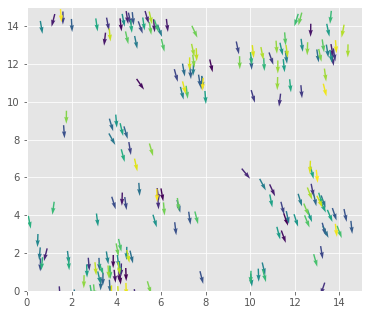

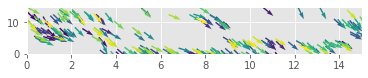

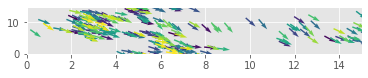

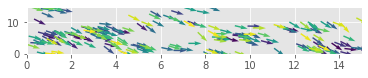

In [62]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 0.1  # variance of noise
T = 10000  # total time steps
Noise_generator = stats.norm(0,sigma)
opara = np.zeros(T) # the Vicsek order parameter
plt.figure(figsize=(6,24))

state = initialize(L,N)
for t in range(T):
    eta = Noise_generator.rvs(N) # noise term
    state = update(state, L, v0, R, eta)
    opara[t]=order_para(state)
    #Initial tests：999 ，3999，6999，9999
    i = 1
    if (t-999)%3000 == 0:
        plt.subplot(4,1,i)
        i += 1
        plt.quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),np.arange(N)) 
        plt.xlim(0,15)
        plt.ylim(0,15)
        plt.show(block=False)

Then for $T=10,000$ steps, we again plot the Vicsek order parameter against the time. 

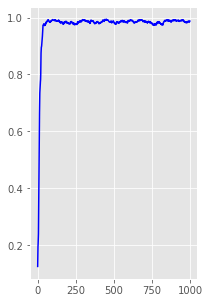

In [58]:
plt.figure(figsize=(3,5))
plt.plot(np.arange(T),opara,'b')    
plt.show()

We use these images as produced above at a variety of time steps to create an animation of the birds' motion for 1000 steps. 

FileNotFoundError: [Errno 2] No such file or directory: 'pics/0.png'

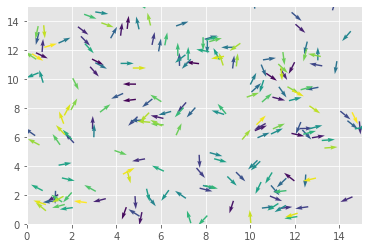

In [11]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 0.1  # variance of noise
T = 10000  # total time steps
Noise_generator = stats.norm(0,sigma)

import os

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
        
createFolder('./pics/')

state = initialize(L,N)
for t in range(T):
    eta = Noise_generator.rvs(N) # noise term
    state = update(state, L, v0, R, eta)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),np.arange(N)) 
    ax.set_xlim(0,15)
    ax.set_ylim(0,15)
    fig.savefig('pics/{}.png'.format(t))
    plt.close(fig)

In [12]:
# make a video
import cv2
import numpy as np

T = 10000
img_array = []
for i in range(T):
    #img = cv2.imread(filename)
    img = cv2.imread('pics/{}.png'.format(i))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

 
 
out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'FMP4'), 12, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

AttributeError: 'NoneType' object has no attribute 'shape'

Now we consider $\sigma=0.5$.

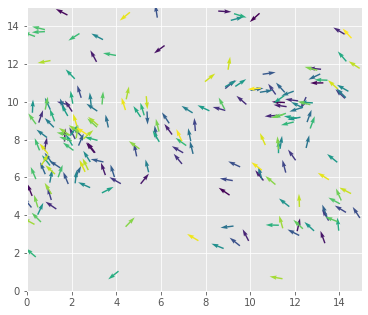

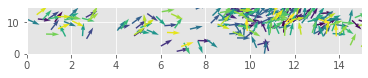

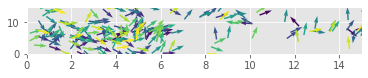

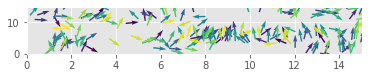

In [59]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 0.5  # variance of noise
T = 10000  # total time steps
Noise_generator = stats.norm(0,sigma)
opara = np.zeros(T) # the Vicsek order parameter
plt.figure(figsize=(6,24))

state = initialize(L,N)
for t in range(T):
    eta = Noise_generator.rvs(N) # noise term
    state = update(state, L, v0, R, eta)
    opara[t]=order_para(state)
    #Initial tests：999 ，3999，6999，9999
    i = 1
    if (t-999)%3000 == 0:
        plt.subplot(4,1,i)
        i += 1
        plt.quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),np.arange(N)) 
        plt.xlim(0,15)
        plt.ylim(0,15)
        plt.show(block=False)

Then for $T=10,000$ steps, we again plot the Vicsek order parameter against the time. 

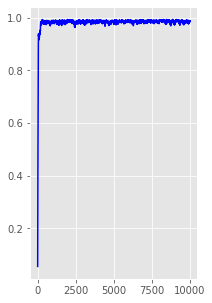

In [63]:
plt.figure(figsize=(3,5))
plt.plot(np.arange(T),opara,'b')    
plt.show()

We use these images as produced above at a variety of time steps to create an animation of the birds' motion for 1000 steps. 

FileNotFoundError: [Errno 2] No such file or directory: 'pics/0.png'

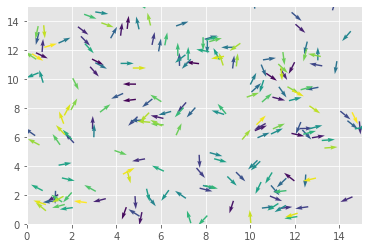

In [11]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 0.5  # variance of noise
T = 1000  # total time steps
Noise_generator = stats.norm(0,sigma)

import os

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
        
createFolder('./pics/')

state = initialize(L,N)
for t in range(T):
    eta = Noise_generator.rvs(N) # noise term
    state = update(state, L, v0, R, eta)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),np.arange(N)) 
    ax.set_xlim(0,15)
    ax.set_ylim(0,15)
    fig.savefig('pics/{}.png'.format(t))
    plt.close(fig)

In [12]:
# make a video
import cv2
import numpy as np

T = 1000
img_array = []
for i in range(T):
    #img = cv2.imread(filename)
    img = cv2.imread('pics/{}.png'.format(i))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

 
 
out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'FMP4'), 12, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

AttributeError: 'NoneType' object has no attribute 'shape'

This time we consider the $\sigma$ value of 1.

In [ ]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 1  # variance of noise
T = 1000  # total time steps
Noise_generator = stats.norm(0,sigma)
opara = np.zeros(T) # the Vicsek order parameter
plt.figure(figsize=(6,24))

state = initialize(L,N)
for t in range(T):
    eta = Noise_generator.rvs(N) # noise term
    state = update(state, L, v0, R, eta)
    opara[t]=order_para(state)
    #Initial tests：999 ，3999，6999，9999
    i = 1
    if (t-999)%3000 == 0:
        plt.subplot(4,1,i)
        i += 1
        plt.quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),np.arange(N)) 
        plt.xlim(0,15)
        plt.xlabel('x')
        plt.ylim(0,15)
        plt.ylabel('y')
        plt.title('Birds positions')
        plt.show(block=False)

Now for $T=10,000$ steps, we plot the Vicsek order parameter (as calculated in the above cell) against the time. 

In [ ]:
plt.figure(figsize=(3,5))
plt.plot(np.arange(T),opara,'b')   
plt.xlabel('t')
plt.ylabel('Vicsek Order Parameter $\sigma$'')
plt.show()

We use these images as produced above at a variety of time steps to create an animation of the birds' motion for 1000 steps. 

In [19]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
sigma = 1  # variance of noise
T = 1000  # total time steps
Noise_generator = stats.norm(0,sigma)

import os

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
        
createFolder('./pics/')

state = initialize(L,N)
for t in range(T):
    eta = Noise_generator.rvs(N) # noise term
    state = update(state, L, v0, R, eta)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),np.arange(N)) 
    ax.set_xlim(0,15)
    ax.set_ylim(0,15)
    fig.savefig('pics/{}.png'.format(t))
    plt.close(fig)

In [17]:
# make a video
import cv2
import numpy as np

T = 1000
img_array = []
for i in range(T):
    #img = cv2.imread(filename)
    img = cv2.imread('pics/{}.png'.format(i))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

 
 
out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'FMP4'), 12, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

AttributeError: 'NoneType' object has no attribute 'shape'

### Phase Transitions

Since we are considering primarily the impact of the order parameter, we update the update function to include this. 

In [64]:
# update the state of birds in each time step
def update_wop(state, L, v0, R, sigma): 
    N=len(state)
    # Initialise heading with noise
    Noise_generator = stats.norm(0,sigma)
    eta = Noise_generator.rvs(N)
    if sigma == 0:
        eta = np.zeros(N)
    heading = eta
        
    
    # Use adjacency matrix to determine neighbours
    A = cal_pdist(state[:,:2],N,L)
    #A =spatial.distance.squareform(spatial.distance.pdist(state[:,:2]))
    for i in range(N):
        adj = np.where(A[i,:] < R)[0] # indices of adjacent particles
        theta = state[adj,2] # angles of all adjacent particles
        
        # Sum sin and cos of angles
        sum_sin = np.sum(np.sin(theta))
        sum_cos = np.sum(np.cos(theta))
        
        # Compute heading for this particle
        heading[i] += np.arctan2(sum_sin, sum_cos)
        
    # Update state with new headings
    state[:,2] = heading 
    # Update positions(mod L)
    state[:,0] = (state[:,0] + v0*np.cos(state[:,2]))%L
    state[:,1] = (state[:,1] + v0*np.sin(state[:,2]))%L
    x = np.sum(np.cos(state[:,2]))
    y = np.sum(np.sin(state[:,2]))
    order_para = np.sqrt(x**2+y**2)/N
    return state,order_para

We want to calculate $n(\sigma)$. In order to do this, we must begin by identifying the time point where system reaches a steady state. We have defined this steady state to be once the Vicsek order parameter is 0.98 or higher. 

In [65]:
#the number of atoms for that particular combination of v0 and R
def burn_in(L,N,v0,R):
    state = initialize(L,N)
    t = 0
    opara = 0
    while opara<0.98:
        state,opara = update_wop(state,L,v0,R,0)
        t+=1
    return t

We can then employ our function which calculates the time value where the system reaches steady state in order to calculate $n(\sigma)$ over the next $T$ time steps. 

In [66]:
def cal_n_sigma(L,N,v0,R,T,sigma_array):
    output = np.zeros((len(sigma_array),2))
    j = 0  # indice for sigma_array
    t = burn_in(L,N,v0,R)  # we calculate the error bar using n(\sigma) after time step t
    res = np.zeros((T+t,len(sigma_array)))
    for sigma in sigma_array:
        state = initialize(L,N)
        for k in range(T+t):
            state,res[k,j] = update_wop(state,L,v0,R,sigma)
        output[j,:] = np.array([np.mean(res[t:,j]),np.std(res[t:,j])])
        plt.figure(figsize=(3,5))
        plt.plot(np.arange(T),res[t:,j],'b')    
        plt.xlabel('time steps')
        plt.ylabel('order parameter of sigma: '+str(sigma))
        plt.ylim(0,1.1)
        plt.show()
        j+=1
    
    df = pd.DataFrame(data=res,index=[i+1 for i in range(res.shape[0])],columns=[str(sigma) for sigma in sigma_array])
    df.to_csv('n_sigma.csv')
    return output

We are now going to compute a $n(\sigma)$ phase transition plot. The parameters we use are:

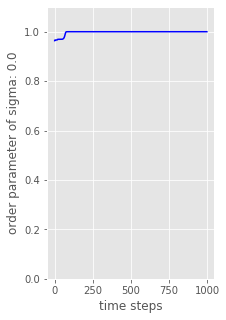

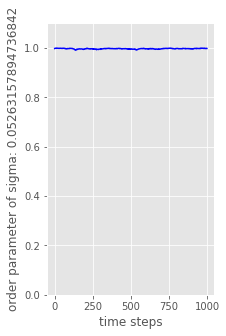

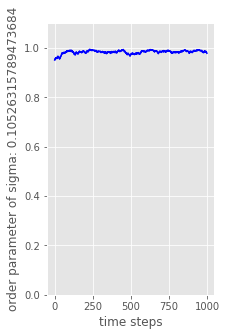

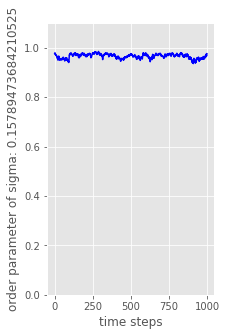

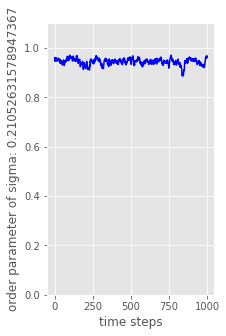

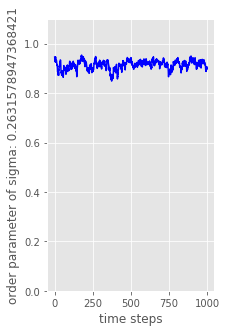

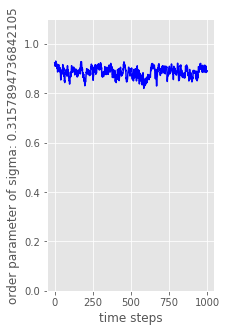

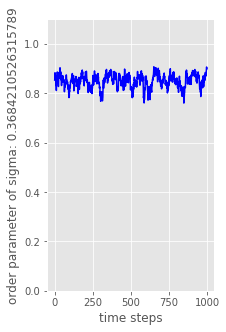

KeyboardInterrupt: 

In [67]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
R = 1 # radius within which to search for neighbours
T = 1000  # total time steps
n_sigma = 20  # number of sigma
sigma_array = np.linspace(0,1,n_sigma)
output = cal_n_sigma(L,N,v0,R,T,sigma_array)

fig, ax = plt.subplots()
ax.errorbar(sigma_array, output[:,0],yerr=output[:,1],fmt='-o')


ax.set_xlabel('sigma')
ax.set_ylabel('error_bar_of_n_sigma')
ax.set_title('Line plot with error bars')

plt.show()

### Predators

We use some functions as defined at the start here, includng importing the same packages, and our functions such as cal_pdist.

Now we want to consider the movement of birds in a container when there is a predator present. You have to create an initial state for the birds and predator to begin in. These are defined as before using uniformly random distributions. 

In [ ]:
# initialize the state of birds and predator
def initialize(L,N,M):
    # prey
    prey = np.zeros((N,3))
    prey[:,:2] = np.random.uniform(0,L,(N,2)) # positions x,y
    prey[:,2] = np.random.uniform(0,2*np.pi,N) # angles theta
    # predator
    predator = np.zeros((M,3))
    predator[:,:2] = np.random.uniform(0,L,(M,2))  # positions x,y
    predator[:,2] = np.random.uniform(0,2*np.pi,M)  # angles theta
    return prey, predator

Then the function to update the orientation of the prey and predator at each discrete time step is:

In [ ]:
# update the state of birds and predator in each time step
def update_pred(state, predator, L, v0, v_predator, R, R_predator, R_run_away, Noise_generator): 
    N = np.shape(state)[0]   # number of birds left
    M = np.shape(predator)[0]  # number of predators
        
    
    # Use adjacency matrix to determine neighbours
    birds = np.concatenate((state,predator),axis=0)
    A = cal_pdist(birds[:,:2],N+M,L)

    I = np.argmin(A[N:,:N],axis=1)  # the index of the bird nearest to the predator
    D = np.amin(A[N:,:N],axis=1)
    dead_bird_index = np.unique(I[D<(0.1)])
    
    state = np.delete(state, dead_bird_index, axis=0)  # delete the dead bird
    A = np.delete(A, dead_bird_index, axis=0)
    A = np.delete(A, dead_bird_index, axis=1)
    N = N-len(dead_bird_index)   # number of birds left decrease by 1     
    
    # Initialise heading
    heading = np.zeros(N)
    
    for i in range(N):
        adj = np.where(A[i,:N] < R)[0] # indices of adjacent particles
        theta = state[adj,2] # angles of all adjacent particles
        
        # Sum sin and cos of angles
        sum_sin = np.sum(np.sin(theta))
        sum_cos = np.sum(np.cos(theta))
        
        # Compute heading for this particle
        heading[i] = np.arctan2(sum_sin, sum_cos)
        
        adj = np.where(A[i,N:] < R_run_away)[0]
        if len(adj) > 0:
            dx = predator[adj,0] - state[i,0]
            dy = predator[adj,1] - state[i,1]
            dx[dx > L/2] -= L
            dx[dx < -L/2] += L
            dy[dy > L/2] -= L
            dy[dy < -L/2] += L  
            dist = np.sqrt(dx**2 + dy**2)
            run_away_angle = np.arctan2(-dy,-dx)
            sum_sin = np.sum(-np.log(dist/R_run_away)*np.sin(run_away_angle)) + np.sin(heading[i])
            sum_cos = np.sum(-np.log(dist/R_run_away)*np.cos(run_away_angle)) + np.cos(heading[i])
            heading[i] = np.arctan2(sum_sin, sum_cos)
                 
    for j in range(M):
        adj = np.where(A[N+j,:N] < R_predator)[0]
        if len(adj) > 0:
            dx = predator[j,0] - state[adj,0]
            dy = predator[j,1] - state[adj,1]
            dx[dx > L/2] -= L
            dx[dx < -L/2] += L
            dy[dy > L/2] -= L
            dy[dy < -L/2] += L  
            dist = np.sqrt(dx**2 + dy**2)
            run_after_angle = np.arctan2(-dy,-dx)
            sum_sin = np.sum(-np.log(dist/R_predator)*np.sin(run_after_angle))
            sum_cos = np.sum(-np.log(dist/R_predator)*np.cos(run_after_angle))
            predator[j,2] = np.arctan2(sum_sin, sum_cos) + Noise_generator.rvs(1) 
            # Update predator positions(mod L)
            predator[j,0] = (predator[j,0] + v_predator*np.cos(predator[j,2]))%L
            predator[j,1] = (predator[j,1] + v_predator*np.sin(predator[j,2]))%L
        else:
            predator[j,2] += Noise_generator.rvs(1) 
            # Update predator positions(mod L)
            predator[j,0] = (predator[j,0] + v0*np.cos(predator[j,2]))%L
            predator[j,1] = (predator[j,1] + v0*np.sin(predator[j,2]))%L
    
    # Update state with new headings
    state[:,2] = heading + Noise_generator.rvs(N)
    # Update positions(mod L)
    state[:,0] = (state[:,0] + v0*np.cos(state[:,2]))%L
    state[:,1] = (state[:,1] + v0*np.sin(state[:,2]))%L
    
    return state, predator

We now create plots of our birds movement at different time steps and save these. BELOW BOX (2) IS FROM OLD CODE _ SEE IF WORKDS OR UPDATE

In [ ]:
N = 200  # number of individual birds
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
v_predator = 0.6 # the constant velocity of the preditor per time step
R = 1 # radius within which to search for neighbours
R_predator = 3.5 # radius within which to catch the preys
R_run_away = R_predator + 0.5  # radius within which the prey spot the predator and try to run away
sigma = 0.01  # variance of noise
T = 300  # total time steps
Noise_generator = stats.norm(0,sigma)
opara = np.zeros(T) # initialise the Vicsek order parameter

state, predator = initialize(L,N)
for t in range(T):
    state, predator = update_pred(state, predator, L, v0, v_predator, R, R_predator, R_run_away, Noise_generator)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),color='k') 
    ax.quiver(predator[0],predator[1],np.cos(predator[2]),np.sin(predator[2]),color='r')
    ax.set_xlim(0,15)
    ax.set_ylim(0,15)
    fig.savefig('pics/{}.png'.format(t))
    plt.close(fig)

We now use cv2 and the plots produced to form an animation of the swarming behaviour of the birds when there is a predator present. 

In [ ]:
# make a video
import cv2
import numpy as np

T = 300
img_array = []
for i in range(T):
    #img = cv2.imread(filename)
    img = cv2.imread('pics/{}.png'.format(i))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

 
 
out = cv2.VideoWriter('eat.mp4',cv2.VideoWriter_fourcc(*'FMP4'), 12, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

Then for 3 predators:

In [ ]:
N = 200  # number of preys
M = 3  # number of predators
L = 15   # size of the container(L*L)
v0 = 0.5  # the constant velocity of the birds per time step
v_predator = 0.6 # the constant velocity of the preditor per time step
R = 1 # radius within which to search for neighbours
R_predator = 3.5 # radius within which to catch the preys
R_run_away = R_predator # radius within which the prey spot the predator and try to run away
sigma = 0.01  # variance of noise
T = 300  # total time steps
Noise_generator = stats.norm(0,sigma)
opara = np.zeros(T) # the Vicsek order parameter

state, predator = initialize(L,N,M)
for t in range(T):
    state, predator = update_pred(state, predator, L, v0, v_predator, R, R_predator, R_run_away, Noise_generator)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.quiver(state[:,0],state[:,1],np.cos(state[:,2]),np.sin(state[:,2]),color='k') 
    ax.quiver(predator[:,0],predator[:,1],np.cos(predator[:,2]),np.sin(predator[:,2]),color='r')
    ax.set_xlim(0,15)
    ax.set_ylim(0,15)
    fig.savefig('pics/{}.png'.format(t))
    plt.close(fig)

In [ ]:
# make a video
import cv2
import numpy as np

T = 300
img_array = []
for i in range(T):
    #img = cv2.imread(filename)
    img = cv2.imread('pics/{}.png'.format(i))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

 
 
out = cv2.VideoWriter('eat.mp4',cv2.VideoWriter_fourcc(*'FMP4'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

### References

# If needed

In [15]:
# update the state of birds in each time step
def update(state, L, v0, R, sigma): 
    N=len(state)
    # Initialise heading with noise
    Noise_generator = stats.norm(0,sigma)
    eta = Noise_generator.rvs(N)
    if sigma == 0:
        eta = np.zeros(N)
    heading = eta
        
    
    # Use adjacency matrix to determine neighbours
    A = cal_pdist(state[:,:2],N,L)
    #A =spatial.distance.squareform(spatial.distance.pdist(state[:,:2]))
    for i in range(N):
        adj = np.where(A[i,:] < R)[0] # indices of adjacent particles
        theta = state[adj,2] # angles of all adjacent particles
        
        # Sum sin and cos of angles
        sum_sin = np.sum(np.sin(theta))
        sum_cos = np.sum(np.cos(theta))
        
        # Compute heading for this particle
        heading[i] += np.arctan2(sum_sin, sum_cos)
        
    # Update state with new headings
    state[:,2] = heading 
    # Update positions(mod L)
    state[:,0] = (state[:,0] + v0*np.cos(state[:,2]))%L
    state[:,1] = (state[:,1] + v0*np.sin(state[:,2]))%L
    x = np.sum(np.cos(state[:,2]))
    y = np.sum(np.sin(state[:,2]))
    order_para = np.sqrt(x**2+y**2)/N
    return state,order_para